In [10]:
import pandas as pd
import numpy as np
from plotnine import *
import os
import math
from scipy.signal import savgol_filter
from stochastic.processes.continuous import FractionalBrownianMotion

In [11]:
jumpdf = pd.read_csv('20min_very_high_patterns/jump.csv')
minute_rate_arr = jumpdf['InvocationsPerMinute'].values

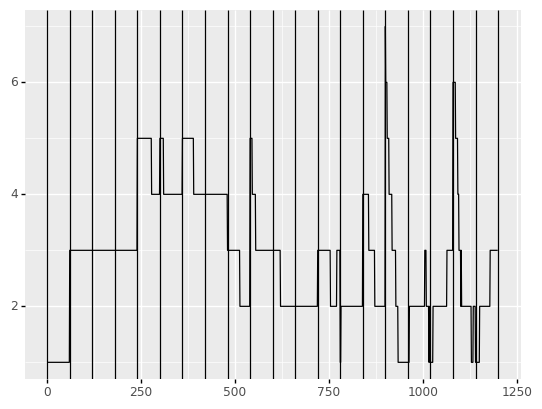

<ggplot: (284522234)>

In [12]:
def upscale(minute_rate_arr):
    bm = FractionalBrownianMotion(hurst=0.8, t=10)
    samples = bm.sample(60 * len(minute_rate_arr)) * 10 # Need to increase magnitude or values become too small
    all_upscaled_samples = samples + np.abs(np.floor(samples.min()))

    per_second_rates = np.array([])
    for i in range(len(minute_rate_arr)):
        current_rate_minute = minute_rate_arr[i]
        upscaled_samples = all_upscaled_samples[i*60:(i+1)*60]

        # Scale random samples by actual request rate per minute
        total_units = upscaled_samples.sum()
        requests_per_unit = current_rate_minute / total_units
        upscaled_samples = np.round(upscaled_samples * requests_per_unit)

        per_second_rates = np.append(per_second_rates, upscaled_samples)
    
    return per_second_rates

per_second_rates = upscale(minute_rate_arr)
ggplot() +\
    geom_line(aes(x=range(len(per_second_rates)), y=per_second_rates)) +\
    geom_vline(aes(xintercept=range(0, 1250, 60)))

In [13]:
# Convert to k6 stages
# Write json

ia = np.array(per_second_rates)
n = len(ia)
element_does_not_match_prev = per_second_rates[1:] != per_second_rates[:-1]
positions_where_element_does_not_match = np.append(np.where(element_does_not_match_prev), n - 1)
run_lengths = np.diff(np.append(-1, positions_where_element_does_not_match))
key_elements = per_second_rates[positions_where_element_does_not_match]

In [14]:
stage_list = []
for i in range(len(key_elements)):
    stage_list.append({
        'duration': str(run_lengths[i]) + 's',
        'target': int(key_elements[i])
    })
config_object = {
    'stages': stage_list,
    'timeUnit': '1s',
    'preAllocatedVUs': 1
}
config_object

{'stages': [{'duration': '60s', 'target': 1},
  {'duration': '180s', 'target': 3},
  {'duration': '38s', 'target': 5},
  {'duration': '22s', 'target': 4},
  {'duration': '10s', 'target': 5},
  {'duration': '50s', 'target': 4},
  {'duration': '30s', 'target': 5},
  {'duration': '90s', 'target': 4},
  {'duration': '33s', 'target': 3},
  {'duration': '27s', 'target': 2},
  {'duration': '6s', 'target': 5},
  {'duration': '9s', 'target': 4},
  {'duration': '66s', 'target': 3},
  {'duration': '99s', 'target': 2},
  {'duration': '34s', 'target': 3},
  {'duration': '17s', 'target': 2},
  {'duration': '9s', 'target': 3},
  {'duration': '2s', 'target': 1},
  {'duration': '58s', 'target': 2},
  {'duration': '16s', 'target': 4},
  {'duration': '16s', 'target': 3},
  {'duration': '28s', 'target': 2},
  {'duration': '1s', 'target': 7},
  {'duration': '4s', 'target': 6},
  {'duration': '5s', 'target': 5},
  {'duration': '8s', 'target': 4},
  {'duration': '10s', 'target': 3},
  {'duration': '6s', 'tar